In [1]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2

from tqdm.notebook import tqdm_notebook as tqdm

import os

In [2]:
real = "/Users/swatiraman/Downloads/Hackathon_DL/train/training_real/"
fake = "/Users/swatiraman/Downloads/Hackathon_DL/train/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [3]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

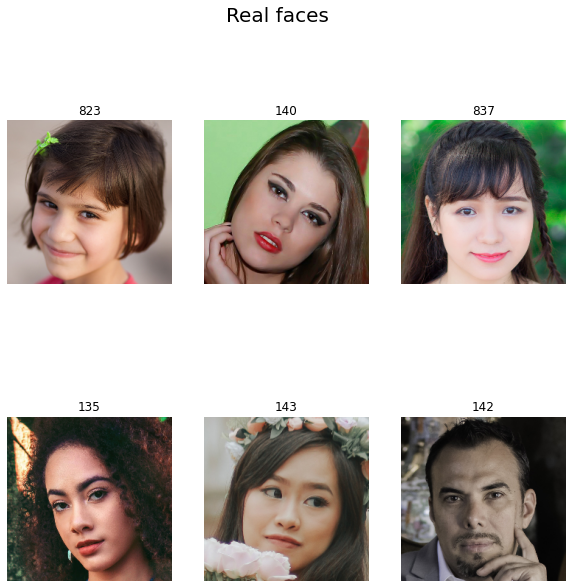

In [4]:
fig = plt.figure(figsize=(10, 10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.title(real_path[i][:3])
    plt.axis('off')

plt.show()

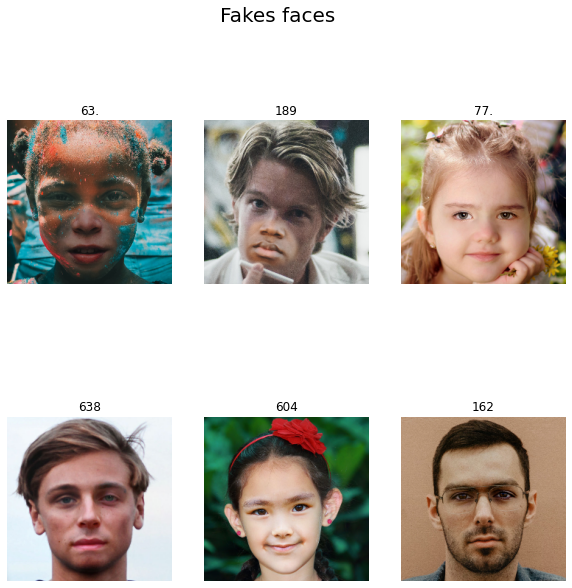

In [5]:
fig = plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:3])
    plt.axis('off')

plt.show()

In [7]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   rotation_range=10.,
                                  validation_split=0.2)

In [8]:
dataset_path = "/Users/swatiraman/Downloads/Hackathon_DL/train"

In [38]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96,96),
                                          batch_size=48,
                                          subset="training")

Found 1368 images belonging to 2 classes.


In [39]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96,96),
                                          batch_size=48,
                                          subset="validation"
                                          )

Found 341 images belonging to 2 classes.


In [40]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(img_dataset,mask_dataset,test_size=0.15,random_state=0)


IMG_HEIGHT=img_dataset.shape[1]
IMG_WIDTH=img_dataset.shape[2]
IMG_CHANNELS=img_dataset.shape[3]

model=simple_unet_model_with_jacard(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

model.fit(x_train,y_train,batch_size=64,verbose=1,epochs=150,
          validation_data=(x_test,y_test),shuffle=False)

In [48]:
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape = (96,96,3),activation = 'relu',padding='same',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])


In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 24, 24, 64)       

In [35]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [50]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [51]:
hist = model.fit(train,
                    epochs=40,
                    callbacks=[lr_callbacks],
                    validation_data=val)

Epoch 1/40
29/29 [==============================] - 21s 720ms/step - loss: 0.7706 - accuracy: 0.5453 - val_loss: 0.6898 - val_accuracy: 0.5543 - lr: 0.0010
Epoch 2/40
29/29 [==============================] - 20s 677ms/step - loss: 0.6916 - accuracy: 0.5563 - val_loss: 0.6914 - val_accuracy: 0.5543 - lr: 0.0010
Epoch 3/40
29/29 [==============================] - 19s 656ms/step - loss: 0.6897 - accuracy: 0.5570 - val_loss: 0.6891 - val_accuracy: 0.5543 - lr: 0.0010
Epoch 4/40
29/29 [==============================] - 19s 662ms/step - loss: 0.6850 - accuracy: 0.5548 - val_loss: 0.6908 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 5/40
29/29 [==============================] - 19s 665ms/step - loss: 0.6870 - accuracy: 0.5607 - val_loss: 0.6894 - val_accuracy: 0.5543 - lr: 0.0010
Epoch 6/40
29/29 [==============================] - 19s 663ms/step - loss: 0.6818 - accuracy: 0.5716 - val_loss: 0.6898 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 7/40
29/29 [==============================] - 20s 673ms/st

In [15]:
test = "/Users/swatiraman/Downloads/Hackathon_DL/test/"

test_path = os.listdir(test)

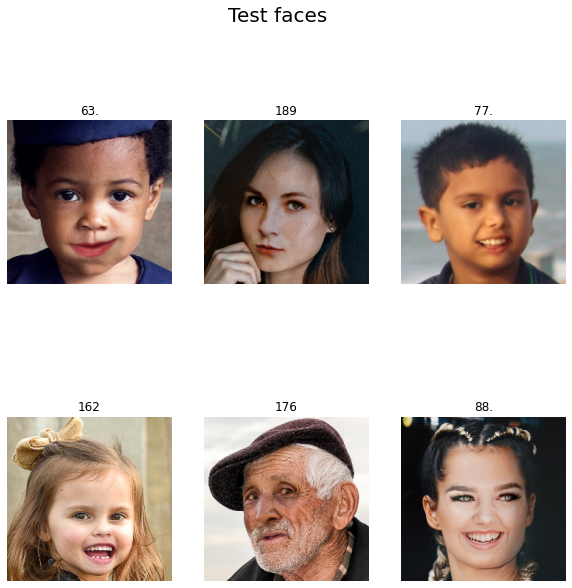

In [16]:
fig = plt.figure(figsize=(10,10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(load_img(test + test_path[i]), cmap='gray')
    plt.suptitle("Test faces",fontsize=20)
    plt.title(test_path[i][:3])
    plt.axis('off')

plt.show()

In [17]:
test = "/Users/swatiraman/Downloads/Hackathon_DL/test/"

test_path = os.listdir(test)

In [18]:
len(test_path)

332

In [19]:
for i in range(len(test_path)):
    image_path = test +'/'+ test_path[i]
    filename = image_path
    unscaled = cv2.imread(filename)
    image_height, image_width, _ = unscaled.shape
    image = cv2.resize(unscaled, (96, 96)) # Rescaled image to run the network
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
    pred = model.predict(x=np.array([feat_scaled]))
    preds = np.argmax(pred)
    print(test_path[i],',',preds)

63.jpg , 0
189.jpg , 0
77.jpg , 0
162.jpg , 0
176.jpg , 0
88.jpg , 0
228.jpg , 1
214.jpg , 0
200.jpg , 1
201.jpg , 0
215.jpg , 1
229.jpg , 0
177.jpg , 0
89.jpg , 1
163.jpg , 1
188.jpg , 0
76.jpg , 1
62.jpg , 0
74.jpg , 0
60.jpg , 1
48.jpg , 1
149.jpg , 0
175.jpg , 0
161.jpg , 1
203.jpg , 1
217.jpg , 1
216.jpg , 1
202.jpg , 1
160.jpg , 1
174.jpg , 1
148.jpg , 1
49.jpg , 0
61.jpg , 1
75.jpg , 0
59.jpg , 0
71.jpg , 0
65.jpg , 1
170.jpg , 1
164.jpg , 0
158.jpg , 0
206.jpg , 0
212.jpg , 0
213.jpg , 1
207.jpg , 0
159.jpg , 1
165.jpg , 0
171.jpg , 1
64.jpg , 1
70.jpg , 0
58.jpg , 0
8.jpg , 1
198.jpg , 1
66.jpg , 0
72.jpg , 0
167.jpg , 0
99.jpg , 0
173.jpg , 0
211.jpg , 0
205.jpg , 0
239.jpg , 1
238.jpg , 1
204.jpg , 0
210.jpg , 0
172.jpg , 0
166.jpg , 0
98.jpg , 0
73.jpg , 0
199.jpg , 0
67.jpg , 0
9.jpg , 1
14.jpg , 0
28.jpg , 1
129.jpg , 1
101.jpg , 0
115.jpg , 1
303.jpg , 1
317.jpg , 1
288.jpg , 0
277.jpg , 0
263.jpg , 1
262.jpg , 0
276.jpg , 0
289.jpg , 1
316.jpg , 1
302.jpg , 0
114.jpg , 

In [ ]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
filename = '/Users/swatiraman/Downloads/Hackathon_DL/test/63.jpg'

unscaled = cv2.imread(filename) 

In [ ]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (96, 96)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
print ("Size of original input: ", image.shape)
print("-------------------------------")
print("Size of scaled input: ", feat_scaled.shape)

In [ ]:
pred = model.predict(x=np.array([feat_scaled])) 

In [ ]:
preds = np.argmax(pred)
print(preds)

In [ ]:
#------------------------end################################